In [1]:
''' Imports and Random Seed'''

# Import the necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
np.random.seed(27)

In [2]:
''' Data Loading'''

# Load the dataset and display its structure and sample records
data = pd.read_csv('spotify-2023.csv', encoding='latin1')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [3]:
''' Data Cleaning and Feature Engineering '''

# Drop the 'track_name', 'artist(s)_name', and 'key' attributes since they are high-cardinality identifiers and/or contain many missing values
cData = data.drop(columns=['track_name', 'artist(s)_name', 'key'])

# Convert the 'in_deezer_playlists' and 'in_shazam_charts' attributes to numeric types and drop any observations with missing entries in those columns
cData['in_deezer_playlists'] = pd.to_numeric(cData['in_deezer_playlists'].astype(str).str.replace(',', ''), errors='coerce')
cData['in_shazam_charts'] = pd.to_numeric(cData['in_shazam_charts'].astype(str).str.replace(',', ''), errors='coerce')
cData.dropna(subset=['in_deezer_playlists', 'in_shazam_charts'], inplace=True)

# Create a days_since_release feature and drop the original date attributes ('released_year', 'released_month', & 'released_day')
date_parts = cData[['released_year', 'released_month', 'released_day']].rename(
    columns={
        'released_year': 'year',
        'released_month': 'month',
        'released_day': 'day'
    }
)
dates = pd.to_datetime(date_parts)
eoy23 = datetime(2023, 12, 31)
cData['days_since_release'] = (eoy23 - dates).dt.days
cData = cData.drop(columns=['released_year', 'released_month', 'released_day'])

# Convert the 'streams' attribute to a numeric type and drop any observations with missing entries in that column
cData['streams'] = pd.to_numeric(cData['streams'].astype(str).str.replace(',', ''), errors='coerce')
cData.dropna(subset=['streams'], inplace=True)

# Encode the 'mode' attribute as a binary variable; Major = 1, Minor = 0
cData['mode'] = cData['mode'].map({'Major': 1, 'Minor': 0})

# Display the structure of the cleaned dataset
cData.info()


<class 'pandas.core.frame.DataFrame'>
Index: 902 entries, 0 to 952
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   artist_count          902 non-null    int64  
 1   in_spotify_playlists  902 non-null    int64  
 2   in_spotify_charts     902 non-null    int64  
 3   streams               902 non-null    float64
 4   in_apple_playlists    902 non-null    int64  
 5   in_apple_charts       902 non-null    int64  
 6   in_deezer_playlists   902 non-null    int64  
 7   in_deezer_charts      902 non-null    int64  
 8   in_shazam_charts      902 non-null    float64
 9   bpm                   902 non-null    int64  
 10  mode                  902 non-null    int64  
 11  danceability_%        902 non-null    int64  
 12  valence_%             902 non-null    int64  
 13  energy_%              902 non-null    int64  
 14  acousticness_%        902 non-null    int64  
 15  instrumentalness_%    902 no

In [4]:
''' Data Splitting '''

# Shuffles and splits the given dataset into two parts based on the specified ratio
def split_data(df, ratio=0.2):
    shuffled = df.sample(frac=1, random_state=27).reset_index(drop=True)
    size = int(len(df) * ratio)
    df2 = shuffled[:size]
    df1 = shuffled[size:]
    return df1, df2

# Split the cleaned dataset into training (80%), validation (10%), and test (10%) sets
train_pool, test_df = split_data(cData, ratio=0.1)
train_df, val_df = split_data(train_pool, ratio=0.1/0.9)

# Separate the features and target variable for each set
X_train = train_df.drop(columns=['streams']).values
y_train = train_df['streams'].values.reshape(-1, 1)

X_val = val_df.drop(columns=['streams']).values
y_val = val_df['streams'].values.reshape(-1, 1)

X_test = test_df.drop(columns=['streams']).values
y_test = test_df['streams'].values.reshape(-1, 1)

In [5]:
''' Data Standardization '''

# Get the mean and standard deviation of each feature in the training set
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
std[std == 0] = 1.0             # Avoid divisions by zero when scaling

# Scale each of the feature sets using z-score normalization
X_train_scaled = (X_train - mean) / std
X_val_scaled = (X_val - mean) / std
X_test_scaled = (X_test - mean) / std

In [6]:
''' Inclusion of the Bias Term '''

# Add a bias term (column of ones) to each of the feature sets
X_train_scaled = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_val_scaled   = np.hstack([np.ones((X_val_scaled.shape[0], 1)), X_val_scaled])
X_test_scaled  = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

In [7]:
''' Evaluation Metrics '''

# Computes the Mean Squared Error (MSE) between true and predicted values
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Computes the Root Mean Squared Error (RMSE) between true and predicted values
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [8]:
''' Ridge Regression Implementation '''

# Implements Ridge Regression optimized via batch gradient descent
class RidgeRegression:
    
    # Initializes the Ridge Regression model with the specified hyperparameters
    def __init__(self, learning_rate, iterations, l2_penalty, rec_history=False):
        self.learning_rate = learning_rate      # Step size for gradient descent
        self.iterations = iterations            # Number of training steps
        self.l2_penalty = l2_penalty            # L2 regularization strength (lambda)
        self.rec_history = rec_history          # Flag to record loss and RMSE
        self.theta = None                       # Model weights

        # Loss and RMSE tracking lists, as necessary
        if rec_history:
            self.train_losses = []
            self.val_losses = []
            self.train_rmse = []
            self.val_rmse = []

    # Computes the Ridge Regression objective value for given data and parameters
    # Ridge Loss: (1/(2m)) * sum((Xθ - y)^2) + λ * sum(θ_without_bias^2)
    def compute_loss(self, X, y):
        m = X.shape[0]              # Number of samples
        y_pred = X @ self.theta     # Model predictions
        residuals = y_pred - y      # Prediction errors

        # Compute the data loss term (half MSE)
        mse_term = (1.0 / (2 * m)) * np.sum(residuals ** 2)

        # Compute the regularization term (excluding the bias)
        theta_reg = self.theta.copy()
        theta_reg[0, 0] = 0.0
        reg_term = self.l2_penalty * np.sum(theta_reg ** 2)

        # Return the total loss
        return mse_term + reg_term

    # Trains the Ridge Regression model using batch gradient descent
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # Initialize the model's weights to zero
        m, n = X_train.shape
        self.theta = np.zeros((n, 1))

        # Perform gradient descent updates for the specified number of iterations
        for _ in range(self.iterations):
            # Generate predictions on the training set
            y_train_pred = X_train @ self.theta

            # Compute the gradient of the loss
            residuals = y_train_pred - y_train
            grad = (1.0 / m) * (X_train.T @ residuals)

            # Add the gradient of the L2 regularization term (excluding the bias)
            theta_reg = self.theta.copy()
            theta_reg[0, 0] = 0.0
            grad += 2 * self.l2_penalty * theta_reg

            # Update the weights
            self.theta -= self.learning_rate * grad

            # Record the training and validation loss and RMSE as necessary
            if self.rec_history:
                # Loss
                train_loss = self.compute_loss(X_train, y_train)
                val_loss = self.compute_loss(X_val, y_val)
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)

                # RMSE
                y_train_pred = X_train @ self.theta
                y_val_pred = X_val @ self.theta
                self.train_rmse.append(rmse(y_train, y_train_pred))
                self.val_rmse.append(rmse(y_val, y_val_pred))

    # Generates predictions for the given feature matrix
    def predict(self, X):
        return X @ self.theta

In [9]:
''' Lambda Tuning '''

# Define potential lambda (L2 penalty) values
lambda_values = [0, 0.01, 0.05, 0.1, 0.3, 1, 3, 10, 30]

# Initialize variables to store the best validation error, lambda, and model
best_val_error = float('inf')
best_lambda = None
best_model = None

# Iterate over each lambda value
for l in lambda_values:
    # Train a Ridge Regression model with the current lambda value
    model = RidgeRegression(learning_rate=0.01, iterations=300, l2_penalty=l, rec_history=True)
    model.fit(X_train_scaled, y_train, X_val_scaled, y_val)

    # Compute validation RMSE for the current model
    y_val_pred = model.predict(X_val_scaled)
    val_rmse = rmse(y_val, y_val_pred)

    # Update the best validation error, lambda, and model if the current model is better
    if val_rmse < best_val_error:
        best_val_error = val_rmse
        best_lambda = l
        best_model = model

    # Output the validation RMSE for the current lambda value
    print(f"λ={l} → Validation RMSE: {val_rmse:.4f}")

# Output the best lambda value based on validation RMSE
print(f"Best λ = {best_lambda} with Validation RMSE: {best_val_error:.4f}")

λ=0 → Validation RMSE: 375862855.8554
λ=0.01 → Validation RMSE: 375426061.4870
λ=0.05 → Validation RMSE: 374284576.1558
λ=0.1 → Validation RMSE: 373969899.5523
λ=0.3 → Validation RMSE: 379740326.5451
λ=1 → Validation RMSE: 416583191.4039
λ=3 → Validation RMSE: 480247509.5067
λ=10 → Validation RMSE: 537884792.4984
λ=30 → Validation RMSE: 563079248.4078
Best λ = 0.1 with Validation RMSE: 373969899.5523


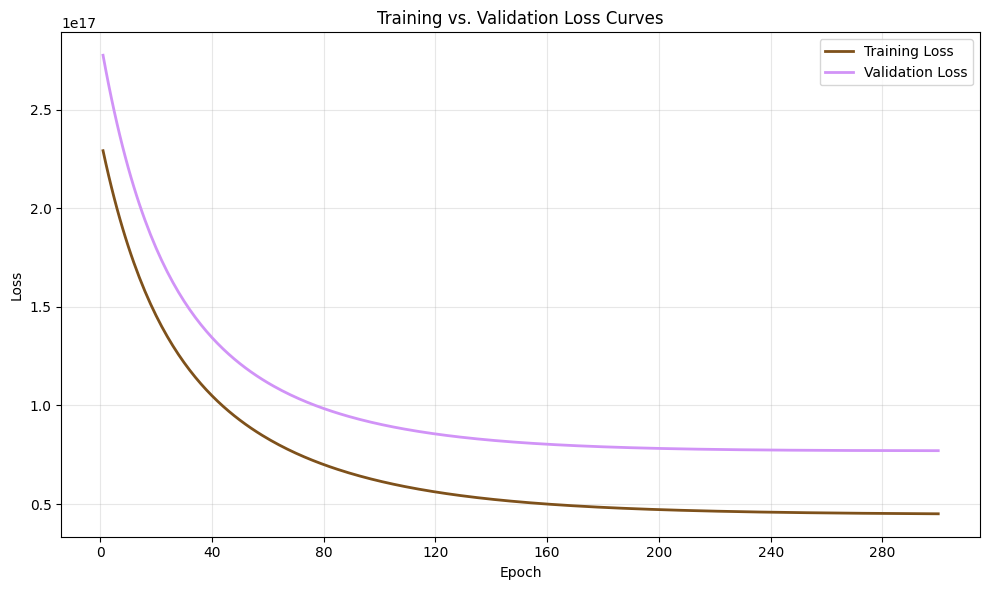

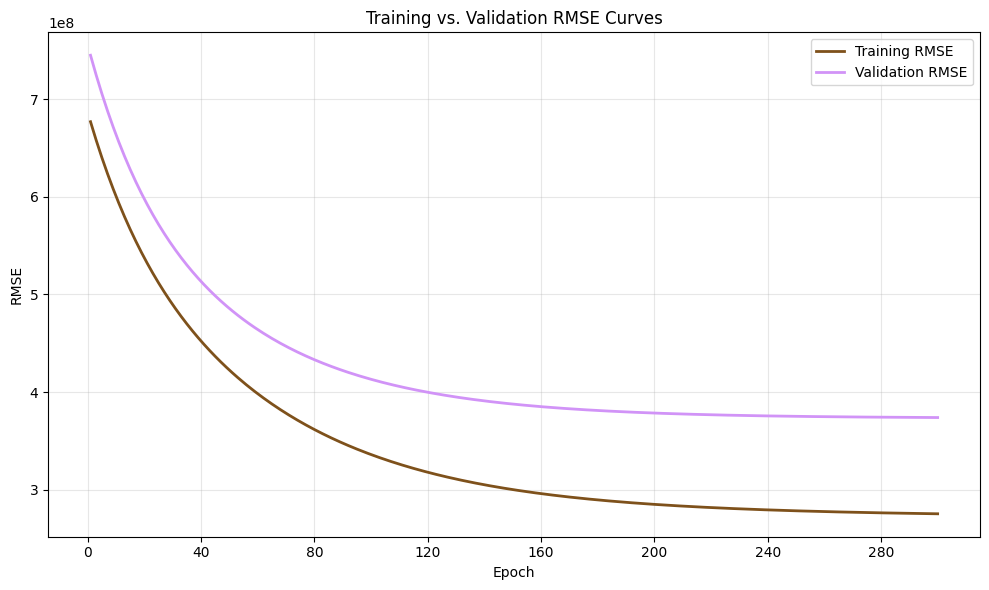

In [10]:
''' Training and Validation Curves '''

# Plots the training and validation curves for a given metric (Loss or RMSE)
def plot_training_metric(train_history, val_history, metric="Loss"):
    epochs = range(1, len(train_history) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_history, label=f"Training {metric}", linewidth=2, color="#7E511B")
    plt.plot(epochs, val_history, label=f"Validation {metric}", linewidth=2, color="#D193F7")

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"Training vs. Validation {metric} Curves")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot the training and validation loss and RMSE curves
plot_training_metric(best_model.train_losses, best_model.val_losses, "Loss")
plot_training_metric(best_model.train_rmse, best_model.val_rmse, "RMSE")

In [11]:
''' Final Model Training '''

# Combine the training and validation sets
X_combined = np.vstack([X_train_scaled, X_val_scaled])
y_combined = np.vstack([y_train, y_val])

# Train the final Ridge Regression model on the combined dataset using the best lambda
final_model = RidgeRegression(learning_rate=0.01, iterations=300, l2_penalty=best_lambda)
final_model.fit(X_combined, y_combined)

In [12]:
''' Final Model Evaluation'''

# Generate predictions on the test set
y_test_pred = final_model.predict(X_test_scaled)

# Compute the evaluation metrics on the test set
test_mse = mse(y_test, y_test_pred)
test_rmse = rmse(y_test, y_test_pred)

# Output the final model's performance on the test set
print("---- Final Model Evaluation on the Test Set ----")
print(f"MSE:  {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")

---- Final Model Evaluation on the Test Set ----
MSE:  68551708010933216.0000
RMSE: 261823811.0083


In [13]:
''' Baseline Model Evaluation '''

# Get the mean of the combined training and validation target values
y_combined_mean = np.mean(y_combined)

# Generate the baseline predictions (mean of combined training and validation targets)
y_test_baseline_pred = np.full_like(y_test, y_combined_mean)

# Compute the evaluation metrics on the test set
baseline_test_mse = mse(y_test, y_test_baseline_pred)
baseline_test_rmse = rmse(y_test, y_test_baseline_pred)

# Output the baseline model's performance on the test set
print("---- Baseline Model Evaluation on the Test Set ----")
print(f"MSE:  {baseline_test_mse:.4f}")
print(f"RMSE: {baseline_test_rmse:.4f}")

---- Baseline Model Evaluation on the Test Set ----
MSE:  308674156574653056.0000
RMSE: 555584517.9400
